In [1]:
%pip install -q --upgrade keras keras-cv tensorflow openpyxl tensorflow_datasets setuptools scikit-learn segmentation-models matplotlib opencv-python seaborn keras_tuner pandas
print("Successfully installed required packages.")


[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
!apt-get update && apt-get install ffmpeg libsm6 libxext6  -y

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Reading package lists... Done
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  alsa-topology-conf alsa-ucm-conf fontconfig fontconfig-config
  fonts-dejavu-core i965-va-driver intel-media-va-driver libaacs0 libaom3
  libasound2 libasound2-data libass9 libasyncns0 libavc1394-0 libavcodec58
  libavdevice58 libavfilter7 libavformat58 libavutil56 libbdplus0 libblas3
  libbluray2 libbs2b0 libcaca0 libcairo-gobject2 libcairo2 libcdio-cdda2
  libcdio-paranoia2 libcdio19 libchromaprint1 libcodec2-1.0 libdatrie1
  libdav1d5 libdc1394-25 libdecor-0-0 libdecor-0

In [2]:
import os
import shutil

import tensorflow as tf
import keras
import keras_cv

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.model_selection import train_test_split

from kfold import copy_files_to_fold, fold_segmented_classification
from evaluations import visualize_confusion_matrices, visualize_history_val_loss, plot_loss_curve, plot_confusion_matrix
import load_model
import gradcam
import openpyxl

2024-09-04 10:29:38.396875: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-04 10:29:38.408404: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-04 10:29:38.421438: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-04 10:29:38.425344: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-04 10:29:38.435192: I tensorflow/core/platform/cpu_feature_guar

In [5]:
split_dir = './segmented_classification/split'

def split_dataset(base_split_dir='./segmented_classification/split', segmented_classification_dir='segmented_classification/overlayed_out', oversampling=False, undersampling=False):
    train_split = 'train'
    test_split = 'test'
    splits = [train_split, test_split]
    normal_class = 'normal'
    tb_class = 'tuberculosis'
    classes = [normal_class, tb_class]

    all_files = [f for f in os.listdir(segmented_classification_dir) if os.path.isfile(os.path.join(segmented_classification_dir, f))]
    normal_files = [f for f in all_files if 'Normal' in f]
    tb_files = [f for f in all_files if 'Tuberculosis' in f]

    if undersampling == True:
        print('Oversampling selected... Setting number of normal samples to: %d' % len(tb_files))
        normal_files = normal_files[:len(tb_files)]

    if os.path.exists(base_split_dir):
        print("Removing existing dataset")
        # If the split directory exists, remove it and so it can be regenerated
        shutil.rmtree(base_split_dir)

    # Split the data into training, test sets
    # The validation set will be created from the training set at a later stage
    train_normal, test_normal = train_test_split(normal_files, test_size=0.1)
    train_tb, test_tb = train_test_split(tb_files, test_size=0.1)

    for split in splits:
        for cls in classes:
            os.makedirs(os.path.join(base_split_dir, split, cls), exist_ok=True)

    def append_filename_suffix(filename, suffix):
        spl = filename.split('.')
        spl[0] += suffix
        return '.'.join(spl)

    # Function to copy files to their respective directories
    def copy_files(file_list, dst_dir, file_suffix=None):
        for file in file_list:
            src_dir = segmented_classification_dir
            if file_suffix:
                shutil.copy(os.path.join(src_dir, file), os.path.join(dst_dir, append_filename_suffix(file, file_suffix)))
            else:
                shutil.copy(os.path.join(src_dir, file), os.path.join(dst_dir, file))

    print("Copying train normal set...")
    copy_files(train_normal, os.path.join(base_split_dir, train_split, normal_class))
    print("Copying test normal set...")
    copy_files(test_normal, os.path.join(base_split_dir, test_split, normal_class))

    if oversampling == True:
        for i in range(int(len(train_normal) / len(train_tb) - 1)):
            print("Copying train tb set (%d)..." % (i + 1))
            copy_files(train_tb, os.path.join(base_split_dir, train_split, tb_class), file_suffix='_%d' % i)
    else:
        print("Copying train tb set...")
        copy_files(train_tb, os.path.join(base_split_dir, train_split, tb_class))
    print("Copying test tb set...")
    copy_files(test_tb, os.path.join(base_split_dir, test_split, tb_class))

split_dataset(base_split_dir=split_dir)

Copying train normal set...
Copying test normal set...
Copying train tb set...
Copying test tb set...


In [6]:
# ~~~~~~~~~~~~~~~~~~~~~ Training ~~~~~~~~~~~~~~~~~~~~~
def build_model():
    regularisation_value = 0.001
    model = keras.Sequential([
        keras.layers.InputLayer(shape=(256, 256, 3)),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(64, (3, 3), activation='relu', strides=2, padding='same', kernel_initializer=keras.initializers.GlorotNormal(), kernel_regularizer=keras.regularizers.L2(regularisation_value)),
        keras.layers.MaxPooling2D(pool_size=2, strides=2),
        keras.layers.Conv2D(128, (3, 3), activation='relu', strides=2, padding='same', kernel_initializer=keras.initializers.GlorotNormal(), kernel_regularizer=keras.regularizers.L2(regularisation_value)),
        keras.layers.MaxPooling2D(pool_size=2, strides=2),
        keras.layers.Conv2D(256, (3, 3), activation='relu', strides=1, padding='same', kernel_initializer=keras.initializers.GlorotNormal(), kernel_regularizer=keras.regularizers.L2(regularisation_value)),
        keras.layers.Conv2D(256, (3, 3), activation='relu', strides=1, padding='same', kernel_initializer=keras.initializers.GlorotNormal(), kernel_regularizer=keras.regularizers.L2(regularisation_value)),
        keras.layers.Conv2D(128, (3, 3), activation='relu', strides=1, padding='same', kernel_initializer=keras.initializers.GlorotNormal(), kernel_regularizer=keras.regularizers.L2(regularisation_value)),
        keras.layers.MaxPooling2D(pool_size=2, strides=2),
        keras.layers.Conv2D(128, (3, 3), activation='relu', strides=1, padding='same', kernel_initializer=keras.initializers.GlorotNormal(), kernel_regularizer=keras.regularizers.L2(regularisation_value)),
        keras.layers.Flatten(),
        keras.layers.Dense(
            4096,
            activation='relu',
            kernel_initializer=keras.initializers.GlorotNormal(),
            kernel_regularizer=keras.regularizers.L2(regularisation_value)
        ),
        keras.layers.Dense(
            4096,
            activation='relu',
            kernel_initializer=keras.initializers.GlorotNormal(),
            kernel_regularizer=keras.regularizers.L2(regularisation_value)
        ),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(1, activation='sigmoid'),
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(
            learning_rate=0.0001,
            beta_1=0.95
        ),
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            'precision',
            'recall',
            keras.metrics.AUC()
        ]
    )

    return model

histories = []
predictions = []
y_true = []

ckpt_dir = 'models/baseline_segmented_evaluation/ckpt'
results_dir = 'results/baseline_segmented_evaluation'

rand_augment = keras_cv.layers.RandAugment(
    value_range=(0, 1),
    augmentations_per_image=3,
    magnitude=0.3,
    magnitude_stddev=0.2,
    rate=10/11,
)

def apply_training_augment(images, labels):
    images = images / 255
    images = rand_augment(images)
    return images, labels

def apply_validation_normalisation(images, labels):
    return images / 255, labels

# This first if statement is to check if we already have the results
# for this model
if os.path.exists(os.path.join(results_dir, 'results.json')) == False:
    # If we do NOT have the results we need to ensure that we
    # remove the existing saved models before continuing
    if os.path.exists(ckpt_dir):
        shutil.rmtree(ckpt_dir)

    split, filenames, y = fold_segmented_classification(undersampling=True)
    for i, (train_idx, test_idx) in enumerate(split):
        # This block ensures that the epoch with the lowest validation loss
        # Is used for evaluation. While not perfect, it should be good enough
        # when using it over 5 folds.
        checkpoint_filepath = '%s/%d-checkpoint.model.keras' % (ckpt_dir, i)
        model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_filepath,
            monitor='val_loss',
            mode='min',
            save_best_only=True
        )
        early_stopping = keras.callbacks.EarlyStopping(
            monitor='val_loss',
            start_from_epoch=10,
            patience=5,
            restore_best_weights=True
        )
        tensorboard_cb = keras.callbacks.TensorBoard('tensorboard/classification/baseline_segmented_evaluation/fold-%d' % i)

        train = filenames[train_idx]
        test = filenames[test_idx]
        copy_files_to_fold(train, test)

        # 10% of the test dataset will be used for validation
        train_dataset, validation_dataset = keras.utils.image_dataset_from_directory(
            './data/folds/train',
            labels='inferred',
            label_mode='binary',
            batch_size=32,
            image_size=(256, 256),
            validation_split=0.1,
            subset='both',
            seed=42
        )

        train_dataset = train_dataset.map(apply_training_augment, num_parallel_calls=tf.data.AUTOTUNE)
        validation_dataset = validation_dataset.map(apply_validation_normalisation, num_parallel_calls=tf.data.AUTOTUNE)

        test_dataset = keras.utils.image_dataset_from_directory(
            './data/folds/test',
            labels='inferred',
            label_mode='binary',
            batch_size=32,
            image_size=(256, 256),
            shuffle=False
        )
        test_dataset = test_dataset.map(apply_validation_normalisation, num_parallel_calls=tf.data.AUTOTUNE)

        model = build_model()
        history = model.fit(
            train_dataset,
            epochs=50,
            validation_data=validation_dataset,
            callbacks=[model_checkpoint_callback, early_stopping, tensorboard_cb]
        )

        histories.append(history)
        predictions.append(model.predict(test_dataset))
        y_true.append(np.concatenate([y for _, y in test_dataset], axis=0).astype(int))

    load_model.save_results(results_dir, histories, predictions, y_true)

Copying train normal set...
Copying test normal set...
Copying train TB set...
Copying test TB set...
Found 836 files belonging to 2 classes.
Using 753 files for training.
Using 83 files for validation.
Found 210 files belonging to 2 classes.
Epoch 1/50


2024-09-04 08:23:54.808269: E tensorflow/core/util/util.cc:131] oneDNN supports DT_INT32 only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.
I0000 00:00:1725438238.960592    3617 service.cc:146] XLA service 0x7f67b0001e30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725438238.960636    3617 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-09-04 08:23:59.374632: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-04 08:23:59.655504: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8906
2024-09-04 08:24:01.892273: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1847', 8 bytes spill stores

 5/24 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4852 - auc_1: 0.4979 - loss: 10.9830 - precision: 0.4214 - recall: 0.5329         

I0000 00:00:1725438245.553175    3617 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


21/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5093 - auc_1: 0.5365 - loss: 10.6209 - precision: 0.4957 - recall: 0.6143

2024-09-04 08:24:07.669433: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1847', 8 bytes spill stores, 8 bytes spill loads

2024-09-04 08:24:08.032833: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1847', 24 bytes spill stores, 24 bytes spill loads

2024-09-04 08:24:08.078349: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1847', 32 bytes spill stores, 32 bytes spill loads

2024-09-04 08:24:08.216805: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1032', 204 bytes spill stores, 204 bytes spill loads

2024-09-04 08:24:08.250472: I external/local_xla/xla/stream_

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.5126 - auc_1: 0.5415 - loss: 10.5549 - precision: 0.5004 - recall: 0.6167

2024-09-04 08:24:13.932184: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_258', 204 bytes spill stores, 204 bytes spill loads

2024-09-04 08:24:14.008568: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_258', 752 bytes spill stores, 972 bytes spill loads



24/24 ━━━━━━━━━━━━━━━━━━━━ 22s 457ms/step - accuracy: 0.5135 - auc_1: 0.5429 - loss: 10.5352 - precision: 0.5016 - recall: 0.6170 - val_accuracy: 0.6867 - val_auc_1: 0.9090 - val_loss: 8.9728 - val_precision: 0.8889 - val_recall: 0.4000
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step - accuracy: 0.6540 - auc_1: 0.7171 - loss: 8.4889 - precision: 0.6983 - recall: 0.5397 - val_accuracy: 0.7590 - val_auc_1: 0.9160 - val_loss: 7.2672 - val_precision: 0.9167 - val_recall: 0.5500
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step - accuracy: 0.6666 - auc_1: 0.7323 - loss: 6.9462 - precision: 0.6697 - recall: 0.6867 - val_accuracy: 0.8313 - val_auc_1: 0.9395 - val_loss: 5.9856 - val_precision: 0.7826 - val_recall: 0.9000
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 114ms/step - accuracy: 0.6989 - auc_1: 0.7771 - loss: 5.7717 - precision: 0.7137 - recall: 0.6369 - val_accuracy: 0.7952 - val_auc_1: 0.9416 - val_loss: 5.0589 - val_precision: 1.0000 - val_recall: 0.5750
Epoch 5/50
24/24 ━━━━━━━━

2024-09-04 08:28:02.589694: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_112', 204 bytes spill stores, 204 bytes spill loads

2024-09-04 08:28:02.679136: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_112', 752 bytes spill stores, 972 bytes spill loads



7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 278ms/step
Removing existing dataset
Copying train normal set...
Copying test normal set...
Copying train TB set...
Copying test TB set...
Found 837 files belonging to 2 classes.
Using 754 files for training.
Using 83 files for validation.


2024-09-04 08:28:03.266645: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Found 209 files belonging to 2 classes.
Epoch 1/50
21/24 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.4502 - auc_2: 0.4797 - loss: 10.6342 - precision: 0.4283 - recall: 0.4120  

2024-09-04 08:28:13.919462: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1847', 8 bytes spill stores, 8 bytes spill loads

2024-09-04 08:28:14.042955: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1847', 32 bytes spill stores, 32 bytes spill loads

2024-09-04 08:28:14.050094: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1847', 32 bytes spill stores, 32 bytes spill loads



24/24 ━━━━━━━━━━━━━━━━━━━━ 15s 317ms/step - accuracy: 0.4565 - auc_2: 0.4839 - loss: 10.5480 - precision: 0.4388 - recall: 0.4309 - val_accuracy: 0.6024 - val_auc_2: 0.8273 - val_loss: 8.9604 - val_precision: 0.5479 - val_recall: 1.0000
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - accuracy: 0.5894 - auc_2: 0.6607 - loss: 8.4762 - precision: 0.5752 - recall: 0.6512 - val_accuracy: 0.6386 - val_auc_2: 0.8828 - val_loss: 7.1570 - val_precision: 1.0000 - val_recall: 0.2500
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - accuracy: 0.6659 - auc_2: 0.7265 - loss: 6.7775 - precision: 0.6595 - recall: 0.6946 - val_accuracy: 0.5904 - val_auc_2: 0.8814 - val_loss: 5.8247 - val_precision: 1.0000 - val_recall: 0.1500
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - accuracy: 0.6649 - auc_2: 0.7422 - loss: 5.5415 - precision: 0.7194 - recall: 0.5744 - val_accuracy: 0.7590 - val_auc_2: 0.8480 - val_loss: 4.8368 - val_precision: 0.7083 - val_recall: 0.8500
Epoch 5/50
24/24 ━━━━━━━━

2024-09-04 08:32:03.969828: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Using 754 files for training.
Using 83 files for validation.
Found 209 files belonging to 2 classes.
Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 13s 218ms/step - accuracy: 0.4823 - auc_3: 0.4839 - loss: 10.5301 - precision: 0.4624 - recall: 0.4899 - val_accuracy: 0.6145 - val_auc_3: 0.8631 - val_loss: 8.9467 - val_precision: 0.9000 - val_recall: 0.2250
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 110ms/step - accuracy: 0.5810 - auc_3: 0.6694 - loss: 8.4676 - precision: 0.6570 - recall: 0.2917 - val_accuracy: 0.7590 - val_auc_3: 0.8552 - val_loss: 7.1556 - val_precision: 0.8125 - val_recall: 0.6500
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - accuracy: 0.6578 - auc_3: 0.7244 - loss: 6.8166 - precision: 0.6420 - recall: 0.7215 - val_accuracy: 0.6988 - val_auc_3: 0.8927 - val_loss: 5.9096 - val_precision: 1.0000 - val_recall: 0.3750
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - accuracy: 0.6394 - auc_3: 0.7653 - loss: 5.6241 - precision: 0.7497 - recall: 0.4037 - val_accuracy: 0.80

2024-09-04 08:40:18.373869: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Copying train TB set...
Copying test TB set...
Found 837 files belonging to 2 classes.
Using 754 files for training.
Using 83 files for validation.
Found 209 files belonging to 2 classes.
Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 13s 221ms/step - accuracy: 0.5247 - auc_5: 0.5341 - loss: 10.5352 - precision: 0.5154 - recall: 0.6675 - val_accuracy: 0.6506 - val_auc_5: 0.8439 - val_loss: 8.9674 - val_precision: 0.5797 - val_recall: 1.0000
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - accuracy: 0.6001 - auc_5: 0.6947 - loss: 8.4877 - precision: 0.5766 - recall: 0.7163 - val_accuracy: 0.7470 - val_auc_5: 0.8785 - val_loss: 7.1760 - val_precision: 0.8800 - val_recall: 0.5500
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - accuracy: 0.6177 - auc_5: 0.6794 - loss: 6.9388 - precision: 0.6012 - recall: 0.7442 - val_accuracy: 0.8072 - val_auc_5: 0.8773 - val_loss: 6.0657 - val_precision: 0.9000 - val_recall: 0.6750
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - accuracy: 0.6828 -

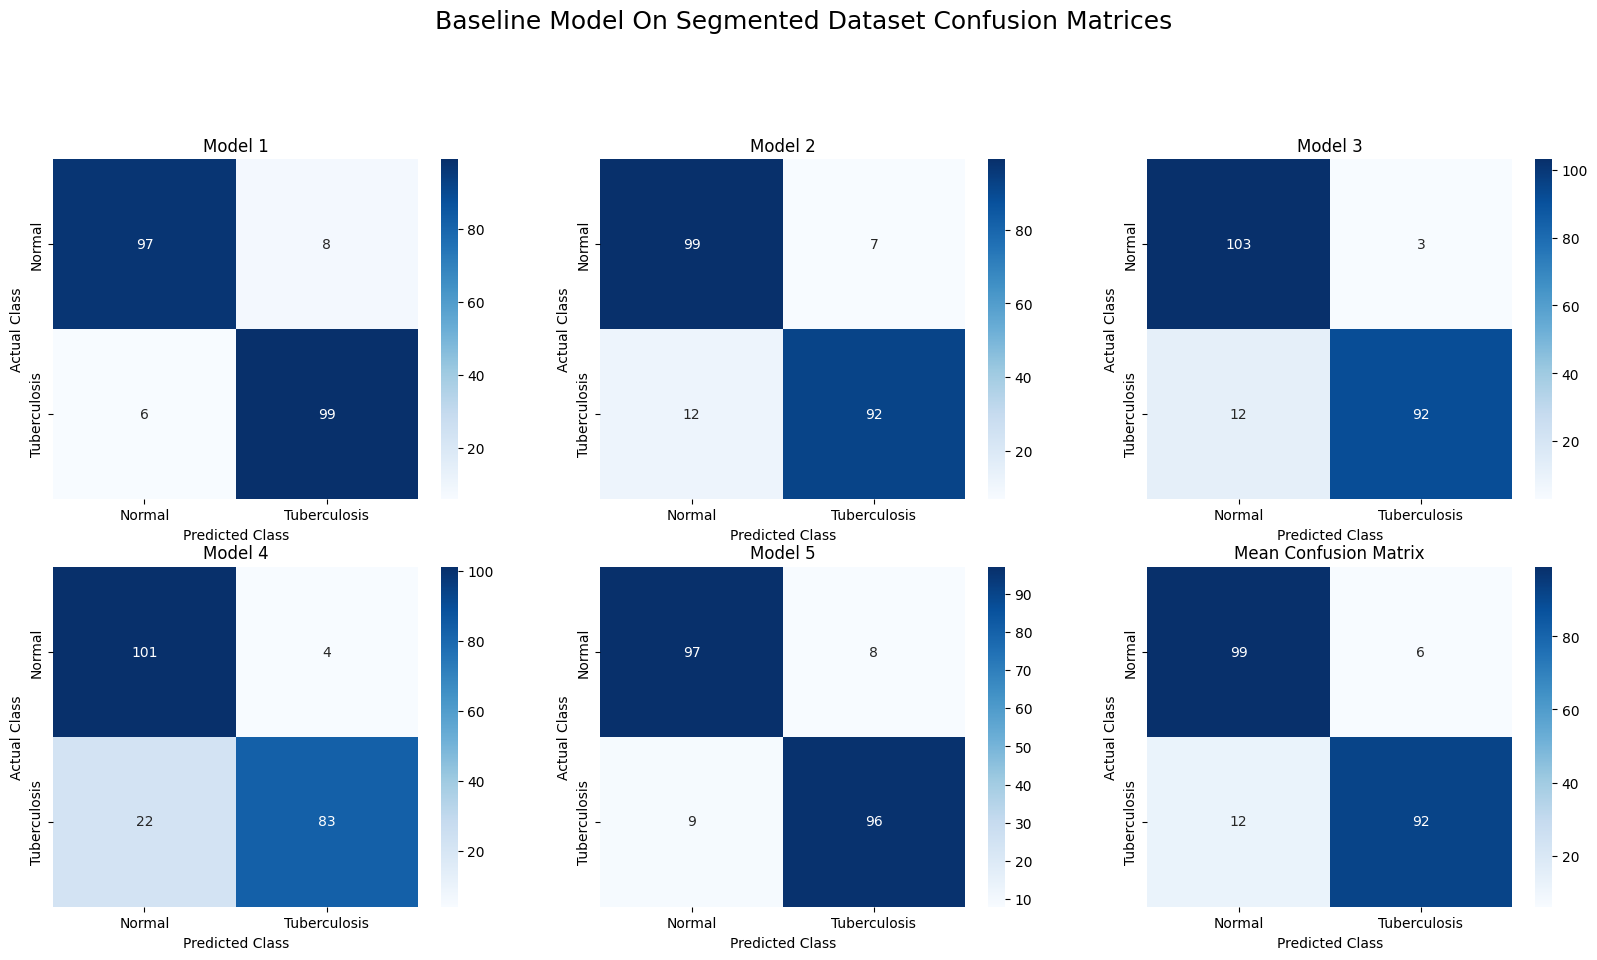

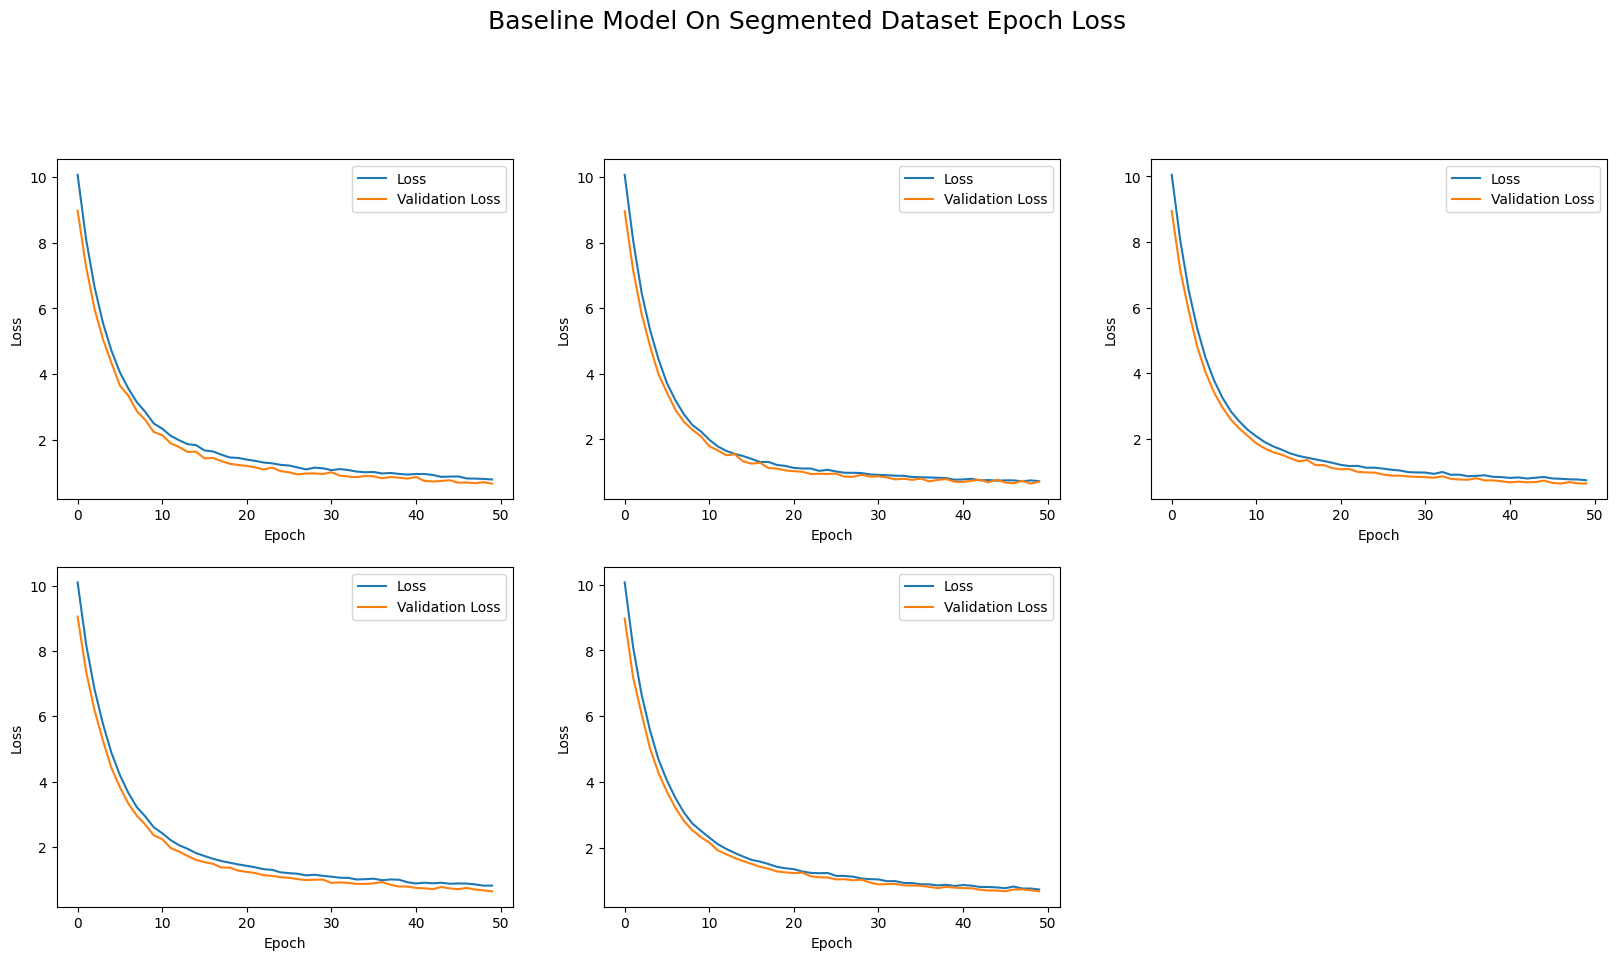

W0000 00:00:1725439487.112872    1200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725439487.130571    1200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725439487.131056    1200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725439487.131462    1200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725439487.131866    1200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725439487.132363    1200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725439487.132755    1200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725439487.133142    1200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725439487.133534    1200 gp

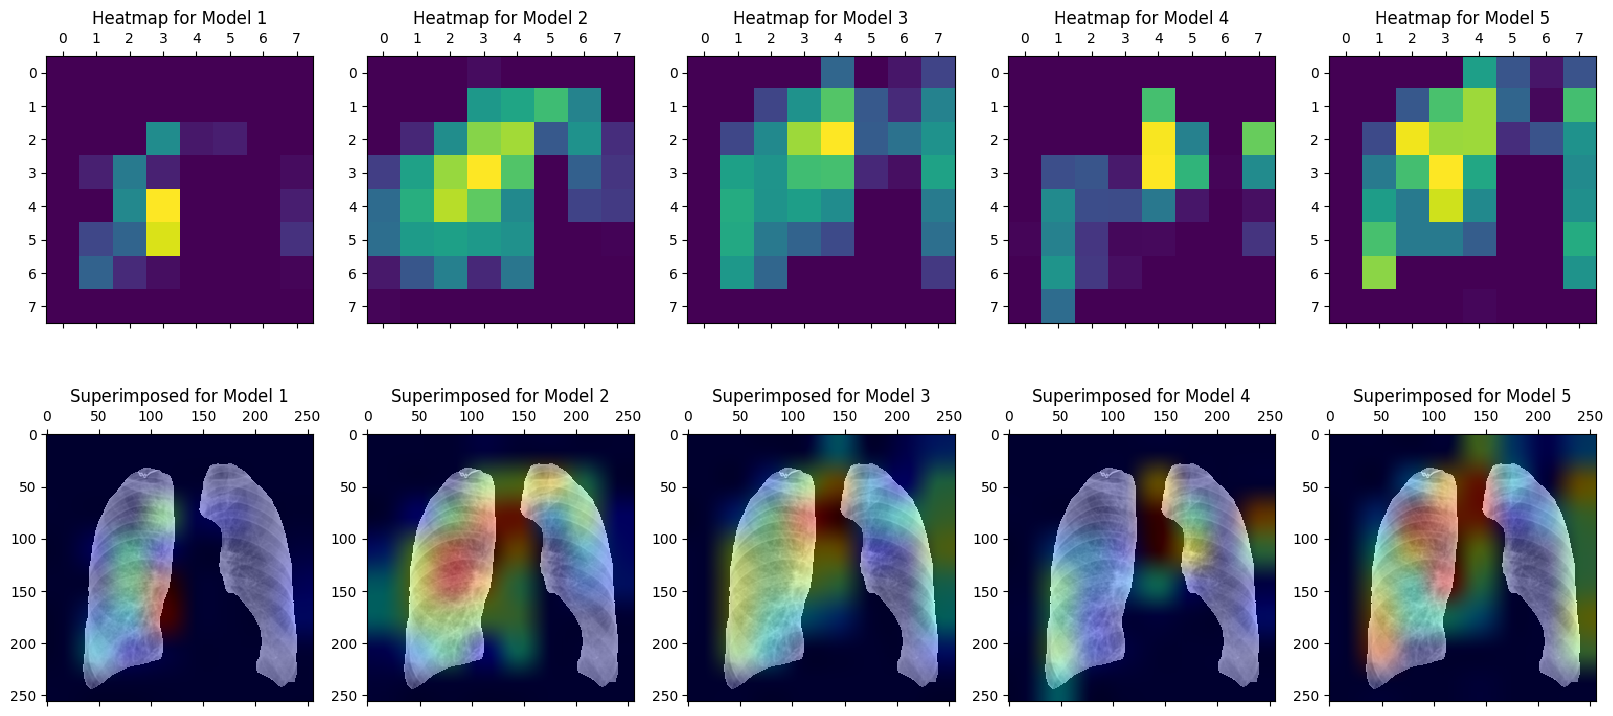

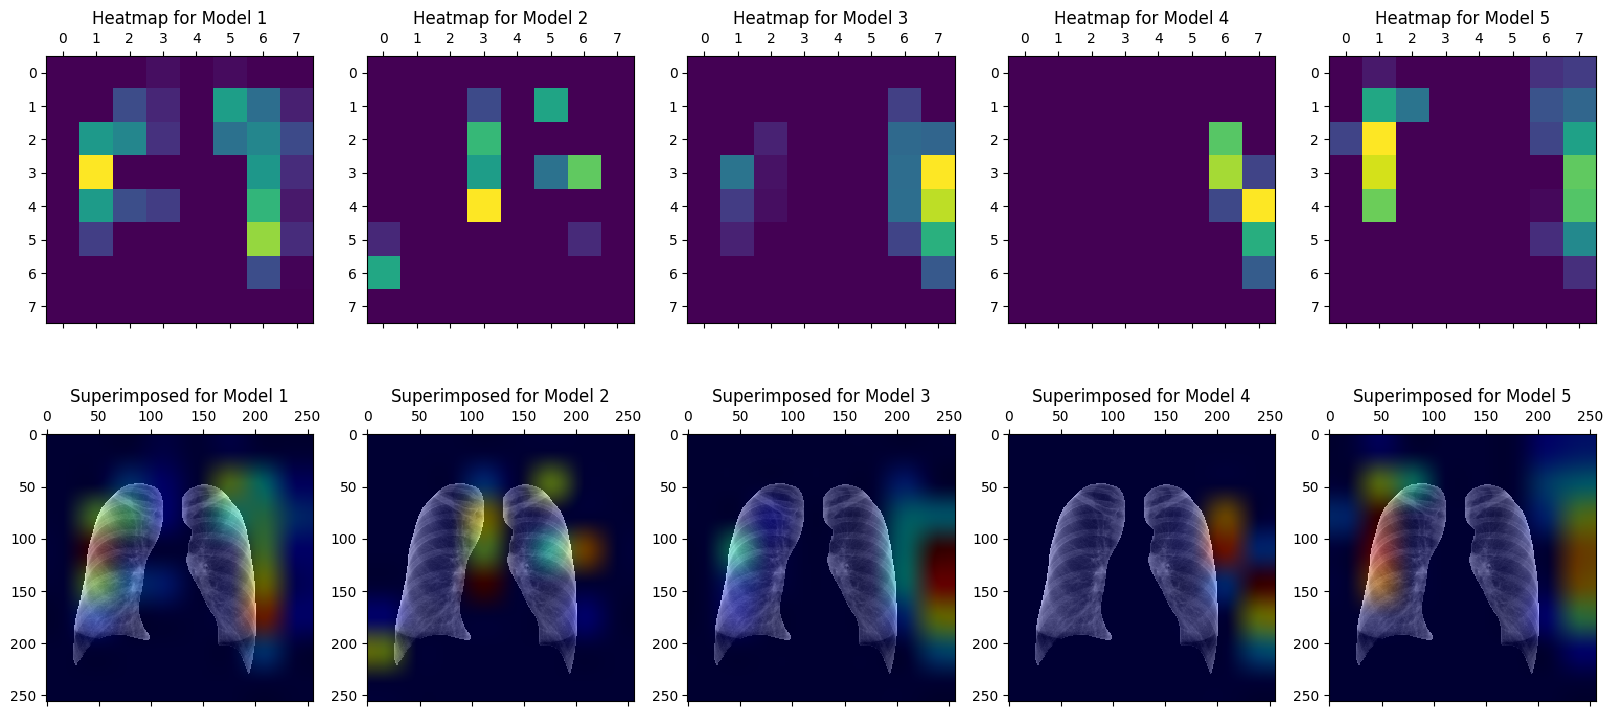

In [7]:
# ~~~~~~~~~~~~~~~~~~~~~ Evaluating ~~~~~~~~~~~~~~~~~~~~~
results = load_model.load_results(results_dir)

predictions = results['predictions']
y_true = results['y_true']
loss = results['loss']
val_loss = results['val_loss']

for pred in predictions:
    if len(pred) == 209:
        pred.append([0.0])

for t in y_true:
    if len(t) == 209:
        t.append([0.0])

y_true = np.array(y_true)
predictions = np.array(predictions)

visualize_confusion_matrices(predictions, y_true, title="Baseline Model On Segmented Dataset Confusion Matrices")
visualize_history_val_loss(loss, val_loss, title="Baseline Model On Segmented Dataset Epoch Loss")

samples = ['Tuberculosis', 'Normal']
for sample in samples:
    img_path = "./segmented_classification/overlayed_out/%s-16.png" % (sample)
    img_array = gradcam.get_img_array(img_path, size=(256, 256), color_mode='rgb')

    folds = len(predictions)
    fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(20, 9))
    for i in range(folds):
        model = load_model.load_model('%s/%d-checkpoint.model.keras' % (ckpt_dir, i))
        model.layers[-1].activation = None

        heatmap = gradcam.make_gradcam_heatmap(img_array, model, layer_idx=9)
        ax[0, i].matshow(heatmap)
        ax[0, i].set_title('Heatmap for Model %d' % (i + 1))
        ax[1, i].matshow(gradcam.overlayed_gradcam(img_array[0], heatmap))
        ax[1, i].set_title('Superimposed for Model %d' % (i + 1))

    plt.show()

## Results

**Accuracy:** 91.39%

**Precision:** 88.46%

**Recall:** 93.88%

**F1-Score:** 91.10%

In [3]:
# ~~~~~~~~~~~~~~~~~~~~~ Training ~~~~~~~~~~~~~~~~~~~~~
def conv_layer(input, filters, kernel_size, **kwargs):
    x = keras.layers.Conv2D(filters, kernel_size, activation=None, **kwargs)(input)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation(keras.activations.relu)(x)

    return x

def build_model():
    inputs = keras.Input(shape=(256, 256, 3))
    x = keras.layers.BatchNormalization()(inputs)
    x = conv_layer(x, 64, (3, 3), strides=2, padding='same', kernel_initializer=keras.initializers.GlorotNormal())
    x = keras.layers.MaxPooling2D(pool_size=2, strides=2)(x)
    x = conv_layer(x, 128, (3, 3), strides=2, padding='same', kernel_initializer=keras.initializers.GlorotNormal())

    y = conv_layer(x, 256, (3, 3), strides=1, padding='same', kernel_initializer=keras.initializers.GlorotNormal())
    y = conv_layer(y, 256, (3, 3), strides=1, padding='same', kernel_initializer=keras.initializers.GlorotNormal())
    y = conv_layer(y, 128, (3, 3), strides=1, padding='same', kernel_initializer=keras.initializers.GlorotNormal())
    y = conv_layer(y, 64, (3, 3), strides=1, padding='same', kernel_initializer=keras.initializers.GlorotNormal())

    x = conv_layer(x, 64, (3, 3), strides=1, padding='same', kernel_initializer=keras.initializers.GlorotNormal())
    x = keras.layers.add([x, y])
    x = keras.layers.MaxPool2D(pool_size=2, strides=2)(x)

    y = conv_layer(x, 256, (3, 3), strides=1, padding='same', kernel_initializer=keras.initializers.GlorotNormal())
    y = conv_layer(y, 256, (3, 3), strides=1, padding='same', kernel_initializer=keras.initializers.GlorotNormal())
    y = conv_layer(y, 128, (3, 3), strides=1, padding='same', kernel_initializer=keras.initializers.GlorotNormal())
    y = conv_layer(y, 64, (3, 3), strides=1, padding='same', kernel_initializer=keras.initializers.GlorotNormal())

    x = conv_layer(x, 64, (3, 3), strides=1, padding='same', kernel_initializer=keras.initializers.GlorotNormal())
    x = keras.layers.add([x, y])

    x = keras.layers.MaxPooling2D(pool_size=2, strides=2)(x)
    x = conv_layer(x, 64, (3, 3), strides=1, padding='same', kernel_initializer=keras.initializers.GlorotNormal())
    x = keras.layers.Flatten()(x)

    x = keras.layers.Dense(
        4096,
        activation=None,
        kernel_initializer=keras.initializers.GlorotNormal(),
    )(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation(keras.activations.relu)(x)

    x = keras.layers.Dense(
        4096,
        activation=None,
        kernel_initializer=keras.initializers.GlorotNormal(),
    )(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation(keras.activations.relu)(x)

    x = keras.layers.Dropout(0.5)(x)
    output = keras.layers.Dense(1, activation='sigmoid')(x)
    model = keras.Model(inputs=inputs, outputs=output)

    model.compile(
        optimizer=keras.optimizers.Adam(
            learning_rate=0.0001,
            beta_1=0.95
        ),
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            'precision',
            'recall',
            keras.metrics.AUC()
        ]
    )

    return model

histories = []
predictions = []
y_true = []

ckpt_dir = 'models/residual_segmentation_evaluation/ckpt'
results_dir = 'results/residual_segmentation_evaluation'

crop = keras.layers.CenterCrop(256, 256)
rand_augment = keras_cv.layers.RandAugment(
    value_range=(0, 1),
    augmentations_per_image=3,
    magnitude=0.3,
    magnitude_stddev=0.2,
    rate=10/11,
)

def apply_training_augment(images, labels):
    images = images / 255
    images = rand_augment(images)
    return images, labels

resize = keras.layers.Resizing(256, 256)
def apply_validation_normalisation(images, labels):
    return images / 255, labels

# This first if statement is to check if we already have the results
# for this model
if os.path.exists(os.path.join(results_dir, 'results.json')) == False:
    # If we do NOT have the results we need to ensure that we
    # remove the existing saved models before continuing
    if os.path.exists(ckpt_dir):
        shutil.rmtree(ckpt_dir)

    split, filenames, y = fold_segmented_classification(undersampling=True)
    for i, (train_idx, test_idx) in enumerate(split):
        # This block ensures that the epoch with the lowest validation loss
        # Is used for evaluation. While not perfect, it should be good enough
        # when using it over 5 folds.
        checkpoint_filepath = '%s/%d-checkpoint.model.keras' % (ckpt_dir, i)
        model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_filepath,
            monitor='val_loss',
            mode='min',
            save_best_only=True
        )
        early_stopping = keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=8,
            start_from_epoch=5,
            restore_best_weights=True
        )
        tensorboard_cb = keras.callbacks.TensorBoard('tensorboard/classification/residual_segmentation_evaluation/fold-%d' % i)

        train = filenames[train_idx]
        test = filenames[test_idx]
        copy_files_to_fold(train, test)

        # 10% of the test dataset will be used for validation
        train_dataset, validation_dataset = keras.utils.image_dataset_from_directory(
            './data/folds/train',
            labels='inferred',
            label_mode='binary',
            batch_size=32,
            image_size=(256, 256),
            validation_split=0.1,
            subset='both',
            seed=42
        )

        train_dataset = train_dataset.map(apply_training_augment, num_parallel_calls=tf.data.AUTOTUNE)
        validation_dataset = validation_dataset.map(apply_validation_normalisation, num_parallel_calls=tf.data.AUTOTUNE)

        test_dataset = keras.utils.image_dataset_from_directory(
            './data/folds/test',
            labels='inferred',
            label_mode='binary',
            batch_size=32,
            image_size=(256, 256),
            shuffle=False
        )
        test_dataset = test_dataset.map(apply_validation_normalisation, num_parallel_calls=tf.data.AUTOTUNE)

        model = build_model()
        history = model.fit(
            train_dataset,
            epochs=50,
            validation_data=validation_dataset,
            callbacks=[model_checkpoint_callback, early_stopping, tensorboard_cb]
        )

        histories.append(history)
        predictions.append(model.predict(test_dataset))
        y_true.append(np.concatenate([y for _, y in test_dataset], axis=0).astype(int))

    load_model.save_results(results_dir, histories, predictions, y_true)

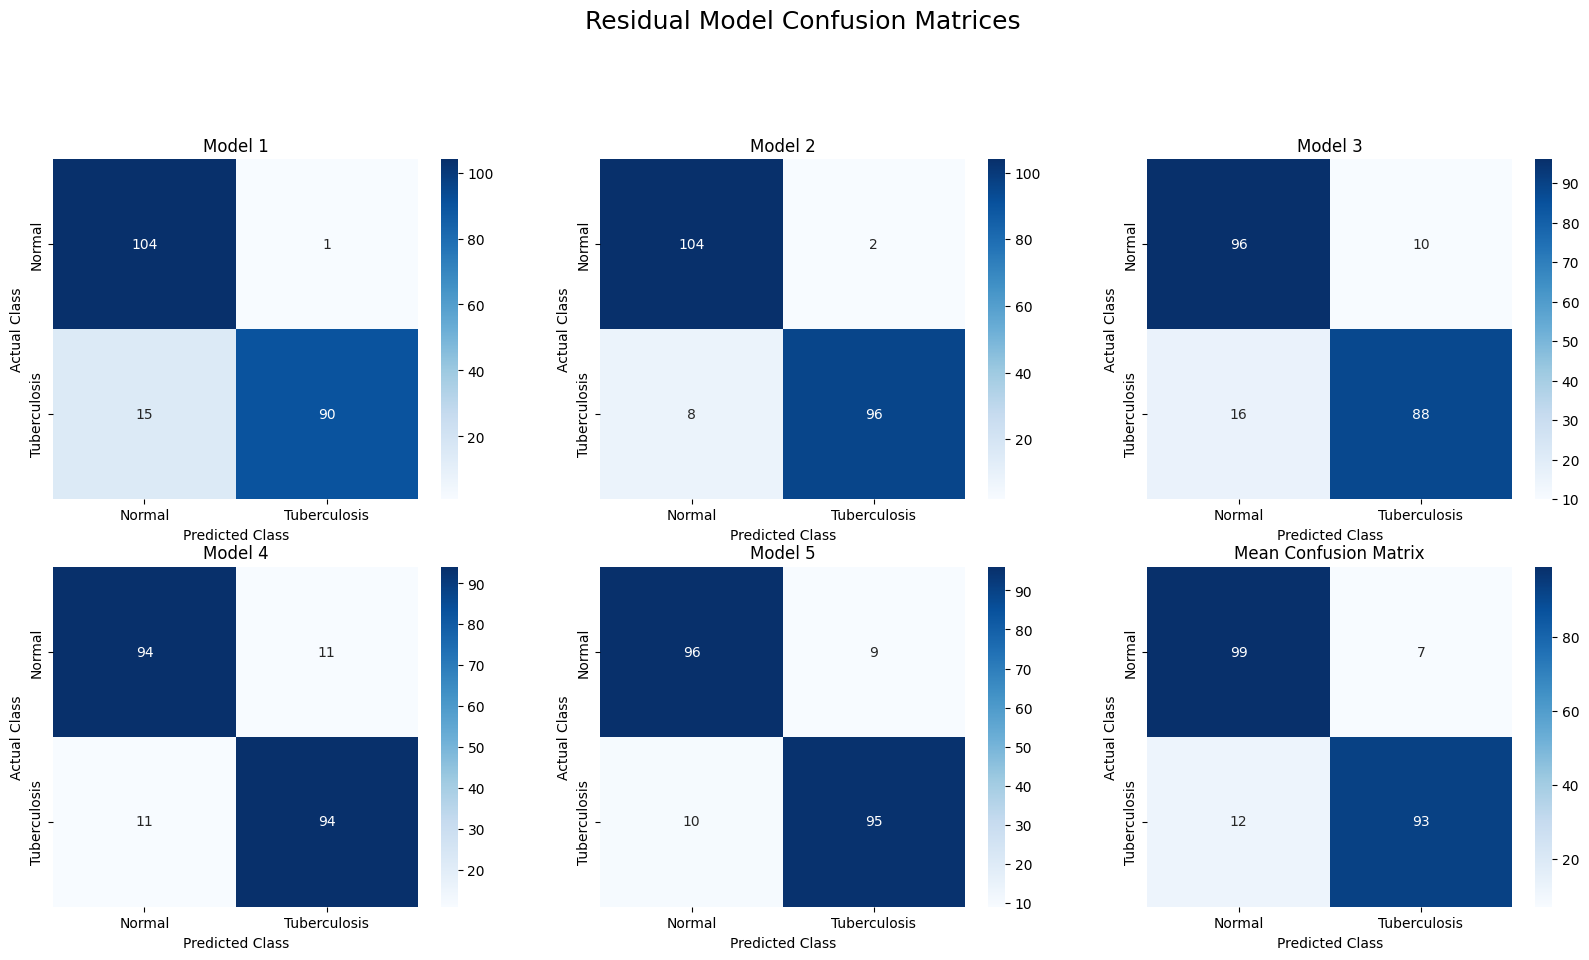

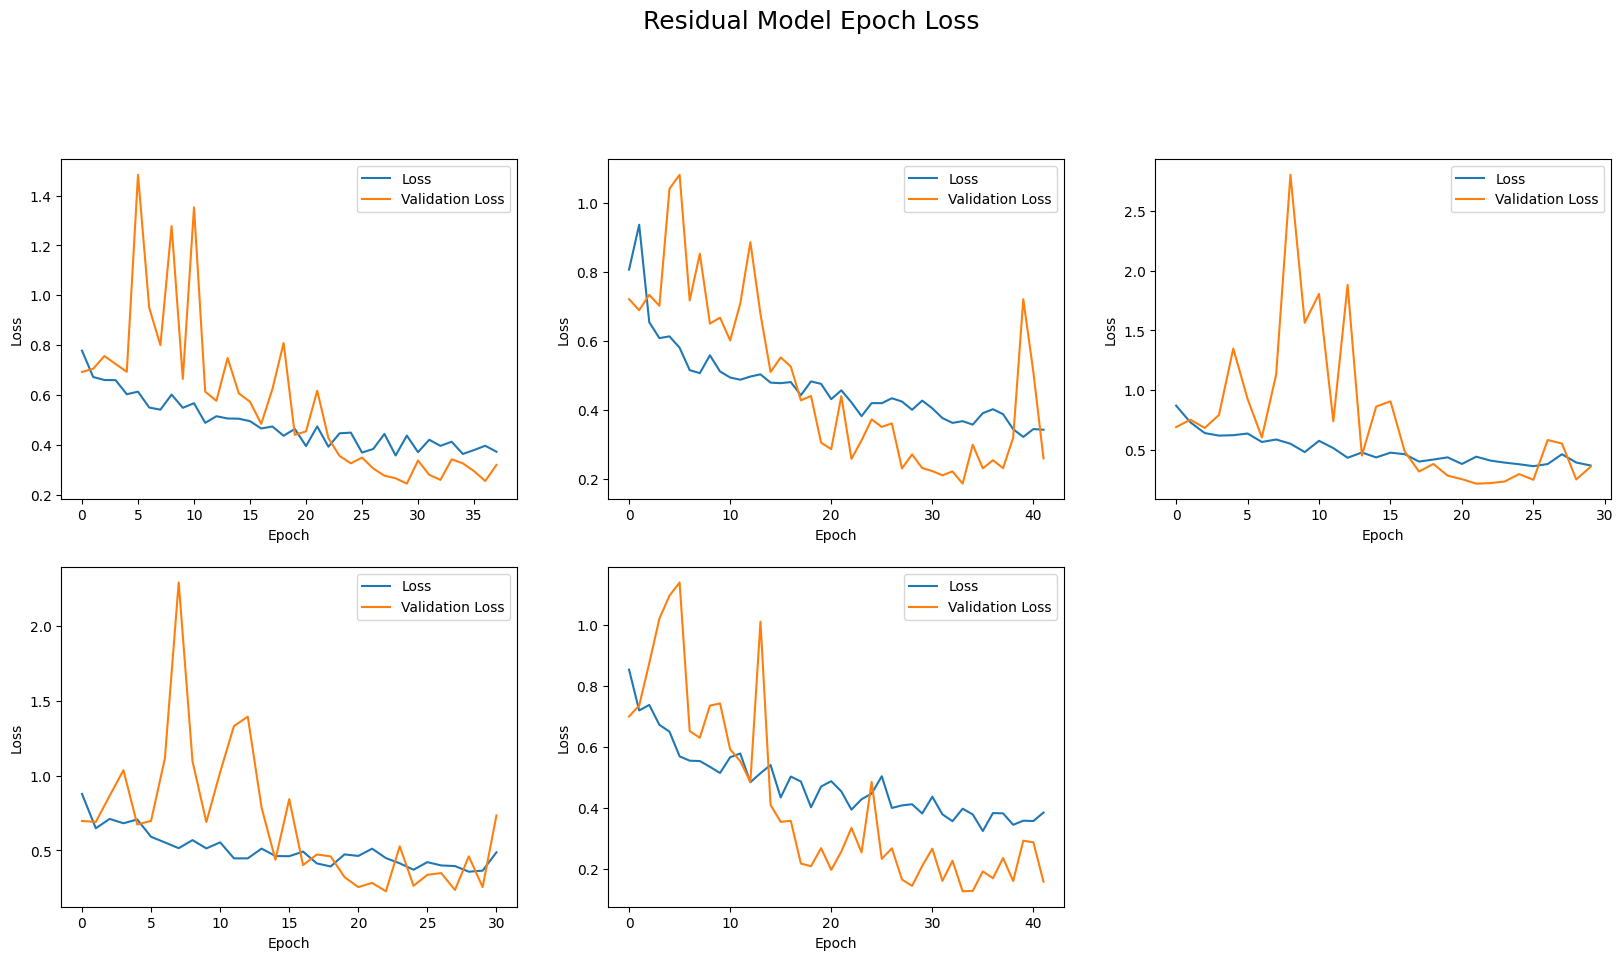

2024-09-04 10:30:00.622975: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8906
W0000 00:00:1725445800.675476  134258 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725445800.691798  134258 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725445800.692226  134258 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725445800.692621  134258 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725445800.693015  134258 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725445800.699320  134258 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725445800.700847  134258 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725445800.702068  134258 gpu_t

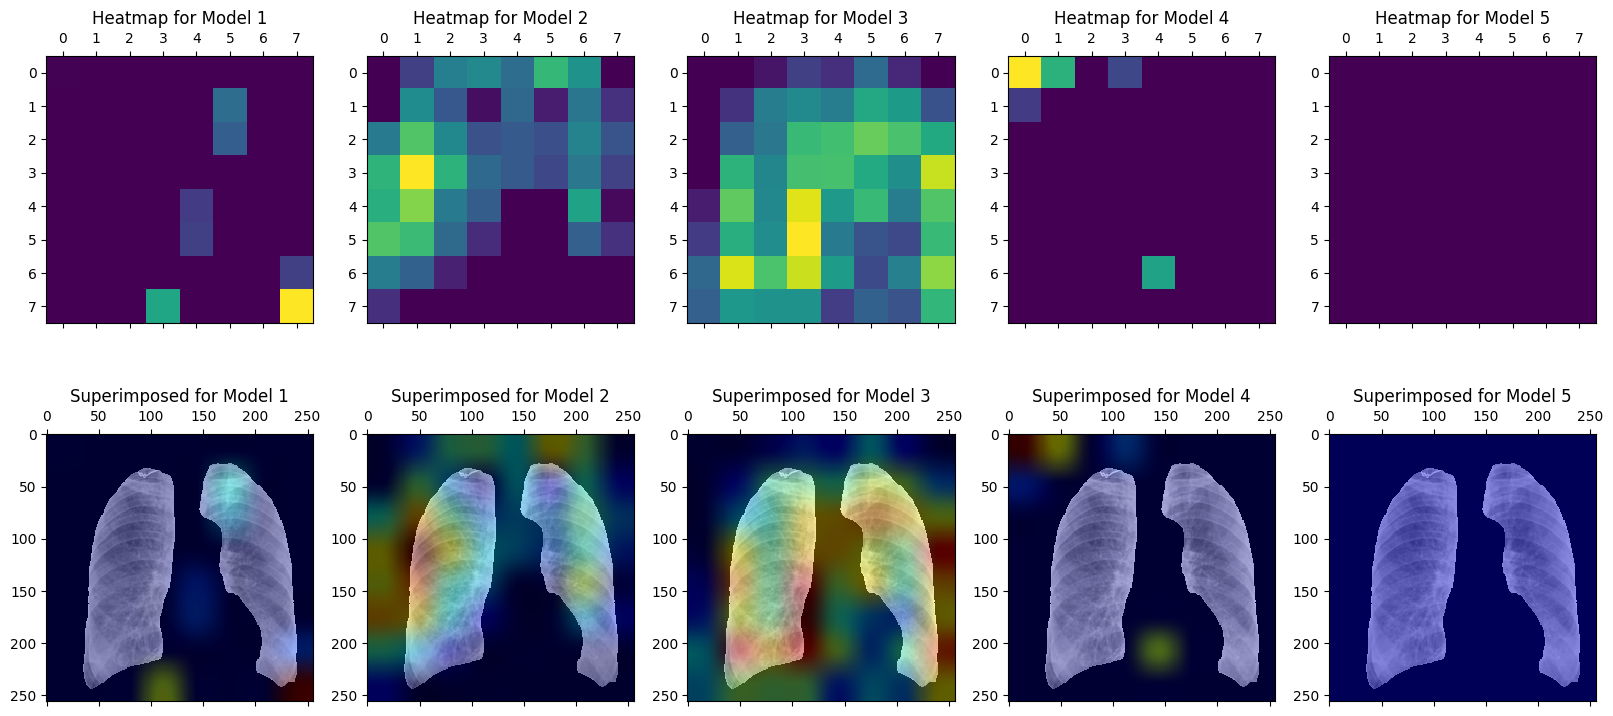

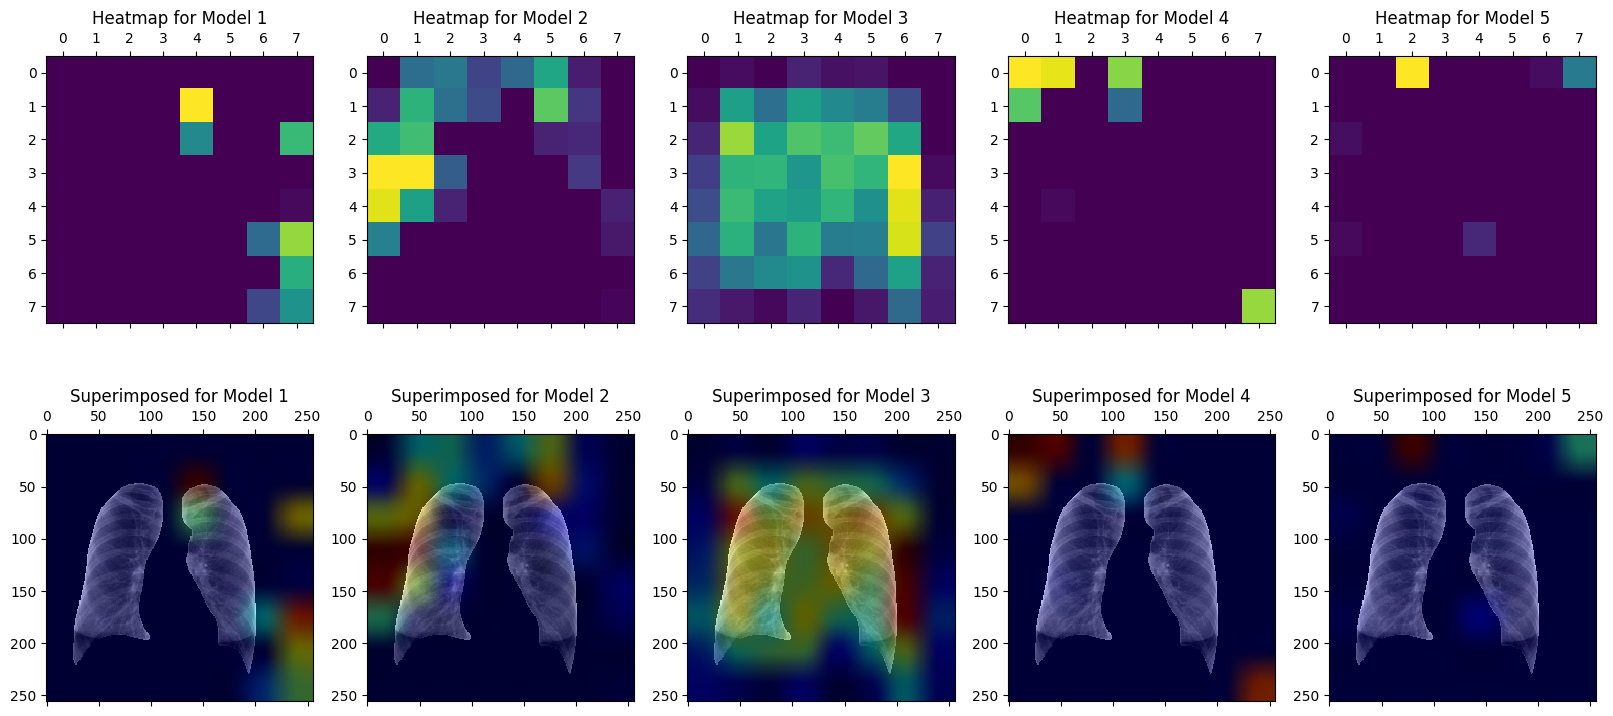

In [4]:
# ~~~~~~~~~~~~~~~~~~~~~ Evaluating ~~~~~~~~~~~~~~~~~~~~~
results = load_model.load_results(results_dir)

predictions = results['predictions']
y_true = results['y_true']
loss = results['loss']
val_loss = results['val_loss']

for pred in predictions:
    if len(pred) == 209:
        pred.append([0.0])

for t in y_true:
    if len(t) == 209:
        t.append([0.0])

y_true = np.array(y_true)
predictions = np.array(predictions)

visualize_confusion_matrices(predictions, y_true, title="Residual Model Confusion Matrices")
visualize_history_val_loss(loss, val_loss, title="Residual Model Epoch Loss")

samples = ['Tuberculosis', 'Normal']
for sample in samples:
    img_path = "./segmented_classification/overlayed_out/%s-16.png" % (sample)
    img_array = gradcam.get_img_array(img_path, size=(256, 256), color_mode='rgb')

    folds = len(predictions)
    fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(20, 9))
    for i in range(folds):
        model = load_model.load_model('%s/%d-checkpoint.model.keras' % (ckpt_dir, i))
        model.layers[-1].activation = None

        heatmap = gradcam.make_gradcam_heatmap(img_array, model, layer_idx=-11)
        ax[0, i].matshow(heatmap)
        ax[0, i].set_title('Heatmap for Model %d' % (i + 1))
        ax[1, i].matshow(gradcam.overlayed_gradcam(img_array[0], heatmap))
        ax[1, i].set_title('Superimposed for Model %d' % (i + 1))

    plt.show()

## Results

**Accuracy:** 91%

**Precision:** 88.57%

**Recall:** 93%

**F1-Score:** 90.73%